Here our goal is to reduce the energy as much as possible, at the same time keep track of the cost.

### Imports

In [1]:
import json
import time
import copy
from pathlib import Path
import numpy as np

import qibo
from qibo import hamiltonians, set_backend
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)


from boostvqe.ansatze import VQE, build_circuit
from boostvqe import utils
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
from boostvqe.models.dbi.double_bracket_evolution_oracles import *

import matplotlib.pyplot as plt

from importlib import reload
reload(utils)

[Qibo 0.2.9|INFO|2024-06-21 14:54:01]: Using numpy backend on /CPU:0


<module 'boostvqe.models.dbi.utils' from '/home/matteo/Documents/PhD/boostvqe/src/boostvqe/models/dbi/utils.py'>

### Help functions

In [2]:
def gradient_numerical_Ising(
    loss_function,
    b_params: list,
    j_params: list,
    loss_0,
    s_0,
    delta: float = 1e-3,
):
    grad_b = np.zeros(len(b_params))
    grad_j = np.zeros(len(j_params))
    for i in range(len(b_params)):
        params_new = deepcopy(b_params)
        params_new[i] += delta
        eo_d = IsingNNEvolutionOracle(params_new, j_params)
        # find the increment of a very small step
        grad_b[i] = (loss_function(s_0, eo_d) - loss_0 ) / delta
    for i in range(len(j_params)):
        params_new = deepcopy(j_params)
        params_new[i] += delta
        eo_d = IsingNNEvolutionOracle(b_params, params_new)
        # find the increment of a very small step
        grad_j[i] = (loss_function(s_0, eo_d) - loss_0 ) / delta
    return grad_b, grad_j

def apply_dbi_sgc(hamiltonian, vqe, dbi_steps, stepsize):
    ham_copy = copy.deepcopy(hamiltonian)
    new_hamiltonian_matrix = utils.rotate_h_with_vqe(hamiltonian=ham_copy, vqe=vqe)
    new_hamiltonian = hamiltonians.Hamiltonian(nqubits=vqe.circuit.nqubits, matrix=new_hamiltonian_matrix)
    
    dbi = DoubleBracketIteration(
        hamiltonian=new_hamiltonian,
        mode=DoubleBracketGeneratorType.single_commutator,
    )
    
    zero_state_t = np.transpose([zero_state])
    energy_h0 = float(dbi.h.expectation(np.array(zero_state_t)))
    
    return utils.apply_dbi_steps(dbi=dbi, nsteps=dbi_steps, stepsize=stepsize)[1][-1]

## Load VQE

In [3]:
import logging
logging.basicConfig(level=logging.ERROR)

qibo.set_backend("numpy")

# set the path string which define the results
path = "../results/vqe_data_mega/with_params/XXZ/sgd_10q_7l_42/"

# set the target epoch to which apply DBQA and the number of steps
target_epoch = 2000
dbi_steps = 1

# upload system configuration and parameters for all the training
with open(path + "optimization_results.json") as file:
    config = json.load(file)

losses = dict(np.load(path + "energies.npz"))["0"]
params = np.load(path + f"parameters/params_ite{target_epoch}.npy")

nqubits = config["nqubits"]
# build circuit, hamiltonian and VQE
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
circuit = build_circuit(nqubits, config["nlayers"], backend="numpy")

vqe = VQE(circuit, hamiltonian)
zero_state = hamiltonian.backend.zero_state(nqubits)
zero_state_t = np.transpose([zero_state])
target_energy = np.min(hamiltonian.eigenvalues())

# set target parameters into the VQE
vqe.circuit.set_parameters(params)
vqe_state = vqe.circuit().state()

ene1 = hamiltonian.expectation(vqe_state)
#s_space = np.geomspace(5e-4, 0.02, 40)

#dbi_energies_list = []
#for s in s_space:
#    dbi_energies_list.append(apply_dbi_sgc(hamiltonian, vqe, 2, s))

[Qibo 0.2.9|INFO|2024-06-21 14:54:11]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-21 14:54:11]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy


#### Single commutator analysis

In [4]:
s_space = np.geomspace(5e-4, 0.02, 40)
dbi_energies_list_1s = np.load("gci_1step.npy")
dbi_energies_list_2s = np.load("gci_2step.npy")

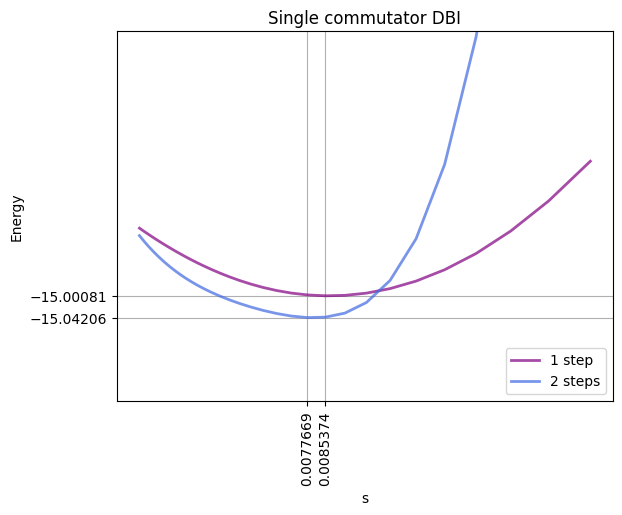

In [5]:
plt.title("Single commutator DBI")
plt.xlabel("s")
plt.ylabel("Energy")
plt.plot(s_space, dbi_energies_list_1s, color="purple", lw=2, alpha=0.7, label="1 step")
plt.plot(s_space, dbi_energies_list_2s, color="royalblue", lw=2, alpha=0.7, label="2 steps")
plt.grid(True)
plt.ylim(-15.2, -14.5)
plt.yticks([min(dbi_energies_list_1s), min(dbi_energies_list_2s)])
plt.xticks([s_space[np.argmin(dbi_energies_list_1s)], s_space[np.argmin(dbi_energies_list_2s)]], rotation=90)
plt.legend(loc=4)
plt.savefig("sgc_check_10q_7l.png", dpi=1000, bbox_inches="tight")

In [6]:
print(f"VQE energy is {ene1}. \n\
The target energy is {target_energy} which means the difference is {ene1-target_energy}.\n\
The relative difference is {abs(ene1-target_energy)/abs(target_energy)*100}%.\n\
The goal is to reach 1.0% which requires to lower energy to {0.99*target_energy}.")

VQE energy is -14.856898957126564. 
The target energy is -15.276131122065788 which means the difference is 0.4192321649392241.
The relative difference is 2.744360869838694%.
The goal is to reach 1.0% which requires to lower energy to -15.12336981084513.


In [7]:
#results = apply_dbi(hamiltonian, vqe, dbi_steps=2, stepsize=0.01)

### Group commutator 3° order

In [8]:
# Initialize transpiler code
eo_xxz = XXZ_EvolutionOracle(nqubits, steps = 1, order = 2)

# implement the rotate by VQE on the level of circuits
fsoe  = VQERotatedEvolutionOracle(eo_xxz, vqe)

# init gci with the vqe-rotated hamiltonian
gci  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced)

In [9]:
# Randomized initial b_list
# 1-local magnetic field
b_list = [4-np.sin(i/3) for i,x in enumerate(np.random.rand(10))]
eo_d = MagneticFieldEvolutionOracle(b_list)
# 2-local Ising model
eo_d_Ising = IsingNNEvolutionOracle(b_list,b_list)

print(eo_d)

### Optimizers 

In [10]:
from scipy.optimize import (
    minimize, 
    dual_annealing,
    differential_evolution
)
import cma

np.random.seed(42)

def loss_function(params, gci, nqubits):
    """``params`` has shape [s0, b_list_0, j_list_0]."""
    eo = IsingNNEvolutionOracle(params[1:nqubits+1], params[nqubits+1:])
    return gci.loss(params[0], eo)


def optimize_ising(params, gci, nqubits, method):
    """Optimize Ising GCI model using chosen optimization `method`."""
    # evolutionary strategy
    if method == "cma":
        lower_bounds = [0.001] + [0.1] * (len(params) - 1)
        upper_bounds = [1e-1] + [10.] * (len(params) - 1)
        bounds = [lower_bounds, upper_bounds]
        opt_results = cma.fmin(
            loss_function, sigma0=0.5, x0=params, args=(gci, nqubits), options={"bounds": bounds},
        )
    # scipy optimizations
    else:
        bounds = [(1e-5, 1e-1)]
        for i in range(len(p0)-1):
            bounds.append((0., 6.))
        # dual annealing algorithm
        if method == "annealing":
            opt_results = dual_annealing(
                func=loss_function, x0=params, bounds=bounds, 
                args=(gci, nqubits), maxiter=500,             
            )
        elif method == "differential_evolution":
             opt_results = differential_evolution(
                func=loss_function, x0=params, bounds=bounds, 
                args=(gci, nqubits), maxiter=500,             
            )           
        # scipy local minimizers
        else:
            opt_results = minimize(
                fun=loss_function, x0=params, bounds=bounds, args=(gci, nqubits), method=method, 
                options={"disp": 1, "maxiter": 20},
            )    
    return opt_results

nqubits = 10
p0 = [0.0085]
b_list0 = [4-np.sin(i/3) for i,x in enumerate(np.random.rand(10)) ]
j_list0 = [4-np.sin(i/3) for i,x in enumerate(np.random.rand(10)) ]
p0.extend(b_list0)
p0.extend(j_list0)

In [ ]:
opt_results = optimize_ising(
    p0, gci, nqubits, method="cma",
)

/home/matteo/Documents/PhD/envs/qibo/lib/python3.10/site-packages/cma/evolution_strategy.py:1901: UserWarning: Sampling standard deviation i=0 at iteration 0 change by 0.066 to stds[0]=0.033
  warnings.warn("Sampling standard deviation i={} at iteration {}"


(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 21 (seed=1101472, Fri Jun 21 14:55:18 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     13 -1.494105233783429e+01 1.0e+00 4.65e-01  3e-02  5e-01 0:03.2
    2     26 -1.494724562379022e+01 1.1e+00 4.24e-01  3e-02  4e-01 0:06.2
    3     39 -1.494730991948908e+01 1.1e+00 3.98e-01  3e-02  4e-01 0:09.4


In [20]:
s_best = opt_results.x[0]
b_list_best = opt_results.x[1:n_components+1]
j_list_best = opt_results.x[n_components+1:]

eo_d_Ising = IsingNNEvolutionOracle(b_list_best, j_list_best)
c0 = gci.group_commutator(s_best, eo_d_Ising)["forwards"]
c1 = gci.get_composed_circuit()
v1_circ = c0+c1
hamiltonian.expectation((v1_circ)().state())

-14.8902209123139

In [21]:
min_loss = opt_results.fun
s_gci_1 = times[np.argmin(losses_2)]
print(f"The minimum energy is achieved by Ising model at {min_loss},\n\
The relative difference is now {abs(min_loss-target_energy)/abs(target_energy)*100}%.")

The minimum energy is achieved by Ising model at -14.8902209123139,
The relative difference is now 2.5262300164107345%.


To further lower the energy, we try a step of gradient descent.